<!-- 
 © Copyright IBM Corporation 2025
 SPDX-License-Identifier: Apache-2.0
 -->


# Terrakit: Labels to dataset pipeline

This notebook demonstrates generating a ML-ready dataset from a collection of labels. The labels used in this example are in GeoJSON format from two wildfire events reported on Copernicus Rapid Mapping Service. The two wildfire events are:

 - [Wildfire in Central Madeira](https://rapidmapping.emergency.copernicus.eu/EMSR748), Portugal, 2024/08/26
 - [Wildfire in Biebrza National Park](https://rapidmapping.emergency.copernicus.eu/EMSR801), Poland, 2025/04/23

<div class="alert alert-block alert-success">
<b>Install Terrakit:</b> For instructions on how to install TerraKit, take a look at the <a href="https://terrastackai.github.io/terrakit/">Welcome</a> page.
</div>

In [1]:
import os

from glob import glob
from pathlib import Path

# Set LOGLEVEL to info for more verbose logging
os.environ["LOGLEVEL"] = "WARNING"

import terrakit

# Import TerraKit Utils
from terrakit.general_utils.labels_downloader import (
    rapid_mapping_geojson_downloader,
    hugging_face_file_downloader,
    EXAMPLE_LABEL_FILES,
    EXAMPLE_RASTER_LABEL_FILES,
)
from terrakit.general_utils.plotting import (
    plot_label_dataframes,
    plot_labels_on_map,
    plot_tiles_and_label_pair,
    plot_chip_and_label_pairs,
)
from terrakit.download.geodata_utils import check_and_crop_bbox

## 1. Process labels
This initial steps takes a directory containing some label files (geojson), and calculates a list of bboxes that encompass the geospatial locations described by the label files. Assuming that the date is included in the label filename, temporal information will also be captured.

The function `process_geojson_labels` returns a Geopandas DataFrame where each row corresponds to a bbox for a given area. The function also saves this information in a shp file. The shp file is output into the working directory (default = `"./tmp"`). 

Either the shp file or the DataFrame can now be used in the next step to tell Terrakit which time and location to download some data from.

In [2]:
# Set a working directory, a dataset name and a directory where some labels can be found
DATASET_NAME = "test_dataset"
WORKING_DIR = f"./tmp/{DATASET_NAME}"
LABELS_FOLDER = "./test_wildfire_vector"


<div class="alert alert-block alert-success">
<b>Example labels:</b> To download a set of example labels, use the `rapid_mapping_geojson_downloader` module.
</div>

In [3]:
# Download some labels if none already exist.
if (
    Path(LABELS_FOLDER).is_dir() is False
    or set(EXAMPLE_LABEL_FILES).issubset(glob(f"{LABELS_FOLDER}/*.json")) is False
):
    rapid_mapping_geojson_downloader(
        event_id="748",
        aoi="01",
        monitoring_number="05",
        version="v1",
        dest=LABELS_FOLDER,
    )
    rapid_mapping_geojson_downloader(
        event_id="801",
        aoi="01",
        monitoring_number="02",
        version="v1",
        dest=LABELS_FOLDER,
    )

.
..
...
>>> Skipping download.
	>>> File already exists: ./terrakit/docs/examples/test_wildfire_vector/EMSR748_AOI01_DEL_MONIT05_observedEventA_v1_2024-08-26.json already exists.
.
..
...
>>> Skipping download.
	>>> File already exists: ./terrakit/docs/examples/test_wildfire_vector/EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json already exists.


In [4]:
# Process the labels by providing a labels folder, working directory and dataset name.
labels_gdf, grouped_bbox_gdf = terrakit.process_labels(
    labels_folder=LABELS_FOLDER,
    dataset_name=DATASET_NAME,
    working_dir=WORKING_DIR,
)
print(labels_gdf)
print(grouped_bbox_gdf)

2026-01-12 15:10:31,426 - INFO - Processing labels with arguments: {'labels_folder': './test_wildfire_vector', 'dataset_name': 'test_dataset', 'working_dir': './tmp/test_dataset', 'active': True, 'label_type': 'vector', 'datetime_info': 'filename'}
2026-01-12 15:10:31,427 - INFO - Processing with parent arguments: dataset_name='test_dataset' working_dir=PosixPath('tmp/test_dataset')
2026-01-12 15:10:31,430 - INFO - Processing labels with arguments: labels_folder=PosixPath('test_wildfire_vector') active=True label_type='vector' datetime_info='filename'
2026-01-12 15:10:31,437 - INFO - Setting datetime to 2025-04-23 and label class to 1 for EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json.
2026-01-12 15:10:31,438 - INFO - Successfully processed ./test_wildfire_vector/EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json
2026-01-12 15:10:31,460 - INFO - Setting datetime to 2024-08-26 and label class to 1 for EMSR748_AOI01_DEL_MONIT05_observedEventA_v1_2024-08-26.json.
202

    event_type                         obj_desc                 det_method  \
0   8-Wildfire  Land fire: Brush, bush, Pasture  Semi-automatic extraction   
1   8-Wildfire  Land fire: Brush, bush, Pasture  Semi-automatic extraction   
2   8-Wildfire                      Forest Fire  Semi-automatic extraction   
3   8-Wildfire                      Forest Fire  Semi-automatic extraction   
4   8-Wildfire                      Forest Fire  Semi-automatic extraction   
5   8-Wildfire                      Forest Fire  Semi-automatic extraction   
6   8-Wildfire                      Forest Fire  Semi-automatic extraction   
7   8-Wildfire                      Forest Fire  Semi-automatic extraction   
8   8-Wildfire                      Forest Fire  Semi-automatic extraction   
9   8-Wildfire                      Forest Fire  Semi-automatic extraction   
10  8-Wildfire                      Forest Fire  Semi-automatic extraction   
11  8-Wildfire                      Forest Fire  Semi-automatic 

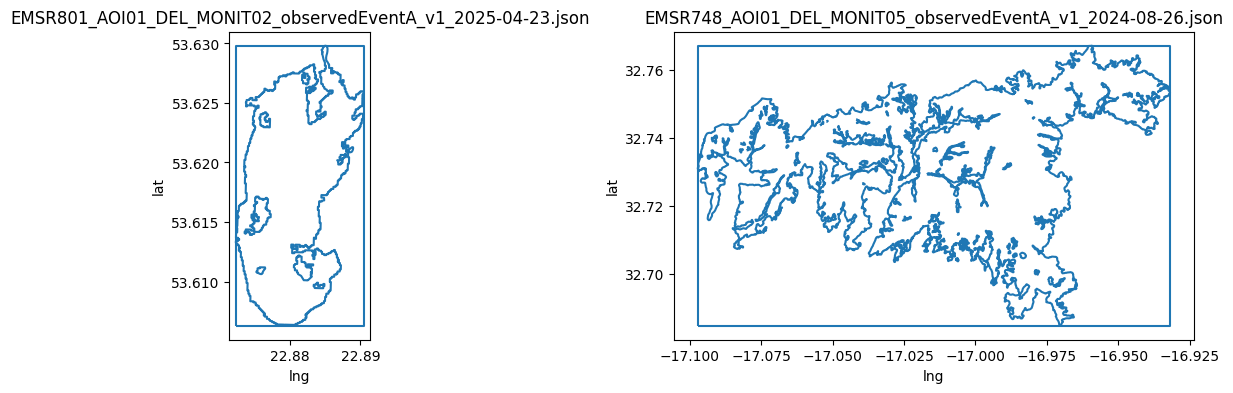

In [5]:
# Plot the process labels and bboxes to confirm they appear as expected.
plot_label_dataframes(labels_gdf, grouped_bbox_gdf)

In [6]:
# Additionally plot labels and bbox on map.
map_collection, title_list = plot_labels_on_map(labels_gdf, grouped_bbox_gdf)
for i in range(0, len(map_collection)):
    print(title_list[i])
    display(map_collection[i])



Download tile bounding box and labels for: EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json





Download tile bounding box and labels for: EMSR748_AOI01_DEL_MONIT05_observedEventA_v1_2024-08-26.json



### Multiple label class example

It's also possible to have label files representing different label classes by including the pattern `_CLASS_1_` in the label file name, in this case the label file would represent class index 1. By default the labels will have class index 1 and everything not represented by the labels would have class index 0. There is also the possibility to set anything not represented by a label as no data with class index -1. In the example below there will be two label classes, and with no data for remaining area, which means that classes for labels are indicies 0 and 1.

In [3]:
# Using a separate working directory, dataset name and an example label folder with multiple classes
CLASSES_DATASET_NAME = "class_test_dataset"
CLASSES_WORKING_DIR = f"./tmp/{CLASSES_DATASET_NAME}"
CLASSES_LABELS_FOLDER = "./test_forest_classes_vector"

In [4]:
# Process the labels by providing a labels folder, working directory and dataset name.
classes_labels_gdf, classes_grouped_bbox_gdf = terrakit.process_labels(
    labels_folder=CLASSES_LABELS_FOLDER,
    dataset_name=CLASSES_DATASET_NAME,
    working_dir=CLASSES_WORKING_DIR,
)
print(classes_labels_gdf)
print(classes_grouped_bbox_gdf)

2026-01-12 15:34:48,721 - INFO - Processing labels with arguments: {'labels_folder': './test_forest_classes_vector', 'dataset_name': 'class_test_dataset', 'working_dir': './tmp/class_test_dataset', 'active': True, 'label_type': 'vector', 'datetime_info': 'filename'}
2026-01-12 15:34:48,721 - INFO - Processing with parent arguments: dataset_name='class_test_dataset' working_dir=PosixPath('tmp/class_test_dataset')
2026-01-12 15:34:48,723 - INFO - Processing labels with arguments: labels_folder=PosixPath('test_forest_classes_vector') active=True label_type='vector' datetime_info='filename'
2026-01-12 15:34:48,729 - INFO - Setting datetime to 2025-06-16 and label class to 1 for 2025-06-16_CLASS_1_other-forest-1.geojson.
2026-01-12 15:34:48,730 - INFO - Successfully processed ./test_forest_classes_vector/2025-06-16_CLASS_1_other-forest-1.geojson
2026-01-12 15:34:48,745 - INFO - Setting datetime to 2025-06-16 and label class to 1 for 2025-06-16_CLASS_1_other-forest-2.geojson.
2026-01-12 15:3

                                              geometry    datetime  \
0    MULTIPOLYGON (((24.73987 45.64889, 24.74029 45...  2025-06-16   
1    MULTIPOLYGON (((24.74144 45.64144, 24.74063 45...  2025-06-16   
2    MULTIPOLYGON (((24.74528 45.63884, 24.74522 45...  2025-06-16   
3    MULTIPOLYGON (((24.74625 45.63393, 24.74609 45...  2025-06-16   
4    MULTIPOLYGON (((24.74625 45.63393, 24.74605 45...  2025-06-16   
..                                                 ...         ...   
339  MULTIPOLYGON (((24.70391 45.63, 24.7038 45.629...  2025-06-16   
340  MULTIPOLYGON (((24.70505 45.63164, 24.70498 45...  2025-06-16   
341  MULTIPOLYGON (((24.70112 45.63788, 24.70109 45...  2025-06-16   
342  MULTIPOLYGON (((24.71068 45.63954, 24.71047 45...  2025-06-16   
343  MULTIPOLYGON (((24.71257 45.64269, 24.71254 45...  2025-06-16   

                                      filename  labelclass  
0    2025-06-16_CLASS_1_other-forest-1.geojson           1  
1    2025-06-16_CLASS_1_other-forest-

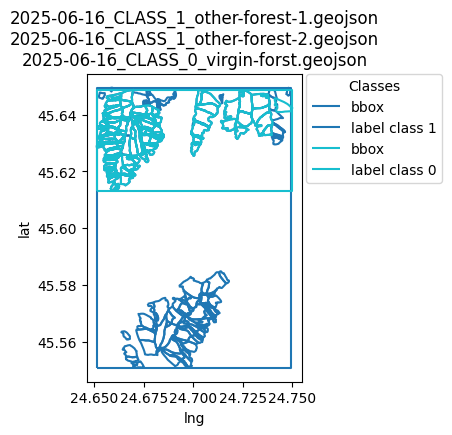

In [5]:
# Plot the process labels and bboxes to confirm they appear as expected.
plot_label_dataframes(classes_labels_gdf, classes_grouped_bbox_gdf)

In [6]:
# Additionally plot labels and bbox on map.
map_collection, title_list = plot_labels_on_map(classes_labels_gdf, classes_grouped_bbox_gdf)
for i in range(0, len(map_collection)):
    print(title_list[i])
    display(map_collection[i])



Download tile bounding box and labels for: 2025-06-16_CLASS_1_other-forest-1.geojson,2025-06-16_CLASS_1_other-forest-2.geojson,2025-06-16_CLASS_0_virgin-forst.geojson



## 2. Download the data

### Example 2.1: Use a shp file to download data

In [ ]:
config = {
    "download": {
        "data_sources": [
            {
                "data_connector": "sentinel_aws",
                "collection_name": "sentinel-2-l2a",
                "bands": ["blue", "green", "red"],
            },
        ],
        "date_allowance": {"pre_days": 0, "post_days": 21},
        "transform": {
            "scale_data_xarray": True,
            "impute_nans": True,
            "reproject": True,
        },
        "max_cloud_cover": 80,
    },
}

queried_data = terrakit.download_data(
    data_sources=config["download"]["data_sources"],
    date_allowance=config["download"]["date_allowance"],
    transform=config["download"]["transform"],
    max_cloud_cover=config["download"]["max_cloud_cover"],
    dataset_name=DATASET_NAME,
    working_dir=WORKING_DIR,
    keep_files=False,
)

### 2.2: Inspect the data
Use the `plot_tiles_and_label_pair` function to inspect the downloaded tiles and corresponding labels.

In [ ]:
plot_tiles_and_label_pair(
    queried_data, bands=config["download"]["data_sources"][0]["bands"]
)

## 3. Chip the data
Now that the tiled data has been downloaded, let's chip it accordingly.

#### 3.1 Example 1: Use the queried data list returned from download_data to find the files to chip.

In [ ]:
chip_args = {
    "chip": {"sample_dim": 256},
}

res = terrakit.chip_and_label_data(
    dataset_name=DATASET_NAME,
    sample_dim=chip_args["chip"]["sample_dim"],
    queried_data=queried_data,
    working_dir=WORKING_DIR,
)

# Note that we can use the working directory to find the list of files to chip.
# Uncomment to try this out.
# res = terrakit.chip_and_label_data(
#     dataset_name=DATASET_NAME,
#     working_dir=WORKING_DIR,
#     sample_dim=chip_args["chip"]["sample_dim"],
#     keep_files=True,
# )

### Check the results
Use the `plot_chip_and_label_pairs` function to check the chip and label pairs look as expected.

In [ ]:
plot_chip_and_label_pairs(
    res, bands=config["download"]["data_sources"][0]["bands"], samples=10
)

## 4. Store

In [ ]:
terrakit.taco_store_data(
    dataset_name=DATASET_NAME,
    working_dir=WORKING_DIR,
    save_dir=WORKING_DIR,
    tortilla_name="terrakit_curated_dataset.tortilla",
)

In [ ]:
import pandas as pd
import tacoreader

df = tacoreader.load("./tmp/test_dataset/terrakit_curated_dataset.tortilla")
splits = ["train", "validation", "test"]
sample_rows = []

for split in splits:
    subset = df[df["tortilla:data_split"] == split]
    if not subset.empty:
        sample_rows.append(subset.iloc[0])  # Take first row

# Create a new DataFrame
sample_df = pd.DataFrame(sample_rows)

# Save back to a new file
tacoreader.compile(sample_df, "./tmp/test_dataset/sampled_dataset.tortilla")



## 5. Upload

## 6. Additional utility functions

In [ ]:
check_and_crop_bbox(bbox=[-73.645550, 44.233885, -72.539635, 44.278023], resolution=10)

# Raster Labels to Data
Let's take a quick look at how we can also use TerraKit to generating a ML-ready dataset from a collection of raster labels. 

The label used in this section are in raster format from two burn scar events included in the [`ibm-nasa-geospatial/hls_burn_scars`](https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars) hugging face dataset.

## 1. Process raster labels
As before, this initial steps takes a directory containing some label files. This time the labels are raster files (.tif). The date is assumed to be contained in the filename again. Supported date types are `YYYYDDD (7), YYYYMMDD (8), YYMMDD (6 -> 20YYMMDD).`

In [ ]:
# Set a working directory, a dataset name and a directory where some labels can be found
DATASET_NAME_RASTER = "test_dataset_raster"
WORKING_DIR_RASTER = f"./tmp/{DATASET_NAME_RASTER}"
LABELS_FOLDER_RASTER = "./test_burn_scar_raster"


<div class="alert alert-block alert-success">
<b>Example labels:</b> To download a set of example raster labels, use the `hugging_face_file_downloader` function.
</div>

In [ ]:
if (
    Path(LABELS_FOLDER_RASTER).is_dir() is False
    or set(EXAMPLE_RASTER_LABEL_FILES).issubset(glob(f"{LABELS_FOLDER_RASTER}/*.tif"))
    is False
):
    for filename in EXAMPLE_RASTER_LABEL_FILES:
        hugging_face_file_downloader(
            repo_id="ibm-nasa-geospatial/hls_burn_scars",
            filename=filename,
            revision="e48662b31288f1d5f1fd5cf5ebb0e454092a19ce",
            subfolder="training",
            dest=LABELS_FOLDER_RASTER,
        )

In [ ]:
labels_gdf, grouped_bbox_gdf = terrakit.process_labels(
    labels_folder=LABELS_FOLDER_RASTER,
    dataset_name=DATASET_NAME_RASTER,
    working_dir=WORKING_DIR_RASTER,
    label_type="raster",
)
print(labels_gdf)
print(grouped_bbox_gdf)

In [ ]:
plot_label_dataframes(labels_gdf, grouped_bbox_gdf)

## 2. Download the data

In [ ]:
config = {
    "download": {
        "data_sources": [
            {
                "data_connector": "sentinel_aws",
                "collection_name": "sentinel-2-l2a",
                "bands": ["blue", "green", "red"],
            },
        ],
        "date_allowance": {"pre_days": 0, "post_days": 21},
        "transform": {
            "scale_data_xarray": True,
            "impute_nans": True,
            "reproject": True,
        },
        "max_cloud_cover": 80,
    },
}
queried_data = terrakit.download_data(
    data_sources=config["download"]["data_sources"],
    date_allowance=config["download"]["date_allowance"],
    transform=config["download"]["transform"],
    max_cloud_cover=config["download"]["max_cloud_cover"],
    dataset_name=DATASET_NAME_RASTER,
    working_dir=WORKING_DIR_RASTER,
    keep_files=False,
)

In [ ]:
plot_tiles_and_label_pair(
    queried_data, bands=config["download"]["data_sources"][0]["bands"]
)

## 3. Chip the data
Now that the tiled data has been downloaded, let's chip it accordingly.

In [ ]:
chip_args = {
    "chip": {"sample_dim": 256},
}

res = terrakit.chip_and_label_data(
    dataset_name=DATASET_NAME_RASTER,
    sample_dim=chip_args["chip"]["sample_dim"],
    queried_data=queried_data,
    working_dir=WORKING_DIR_RASTER,
)

In [ ]:
plot_chip_and_label_pairs(
    res, bands=config["download"]["data_sources"][0]["bands"], samples=10
)

## 4. Store

In [ ]:
terrakit.taco_store_data(
    dataset_name=DATASET_NAME_RASTER,
    working_dir=WORKING_DIR_RASTER,
    save_dir=WORKING_DIR_RASTER,
    tortilla_name="terrakit_curated_dataset.tortilla",
)